In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io

In [3]:
# Load the JSON file
with open('temp/image-scoring.image-scoring-pilot.json', 'r') as f:
    data = json.load(f)

data

[{'_id': {'$oid': '696ae4853e1ee7480e23614c'},
  'study_metadata': {'project': 'image-scoring',
   'experiment': 'image-scoring-pilot',
   'version': '1.0.0',
   'study_description': 'generating sounds from visual cues',
   'date': '2026-01-17',
   'time': '01:23:09'},
  'session_info': {'condition': 'musical', 'stimulus': 'A'},
  'prolific': {'prolificStudyID': '6969ebeb7f113818316ecead',
   'prolificSessionID': '696ae4736a1fe3a94cc2de95',
   'prolificID': '694203dedb9fa28fde0a812a'},
  'study_phase': 'consent',
  'rt': 7400,
  'stimulus': '<div style="padding: 0 100px;"><h2>Make Some Sounds!</h2><div style="text-align: left"><p>Welcome! In this study you will watch animated video clips and make sounds using a web interface. The session should take about <b>15–20 minutes</b>.</p><div class=\'consent\'><p>By clicking below, you are agreeing to take part in a study being conducted by cognitive scientists in the <b>Department of Psychology at Stanford University</b>. If you have question

In [6]:
# extract all the entries in data tagged "study_phase": "scoring_trial"
scoring_trials = [entry for entry in data if entry.get('study_phase') == 'scoring_trial']
print(f'Found {len(scoring_trials)} scoring trials')

Found 36 scoring trials


In [52]:
def plot_interactions(interactions_array, title):
    plt.figure(figsize=(6, 5))
    
    for interactions in interactions_array:
        x_coords = []
        y_coords = []
        timestamps = []
        for interaction in interactions:
            if isinstance(interaction, list):
                interaction = interaction[-1]
            try:
                x_coords.append(interaction['x'])
                y_coords.append(interaction['y'])
            except KeyError:
                continue
            timestamps.append(interaction['timestamp']/1000)
        
        plt.scatter(x_coords, y_coords, c=timestamps, cmap='viridis', s=40, alpha=(1/len(interactions_array))**0.5, edgecolors='none')
    
    plt.colorbar(label='Time (s)')
    plt.xlabel('pitch')
    plt.ylabel('vibrato')
    plt.xlim([0, 400])
    plt.ylim([400, 0])
    plt.xticks(np.arange(0, 401, 100))
    plt.yticks(np.arange(0, 401, 100))
    plt.title(title)
    plt.show()

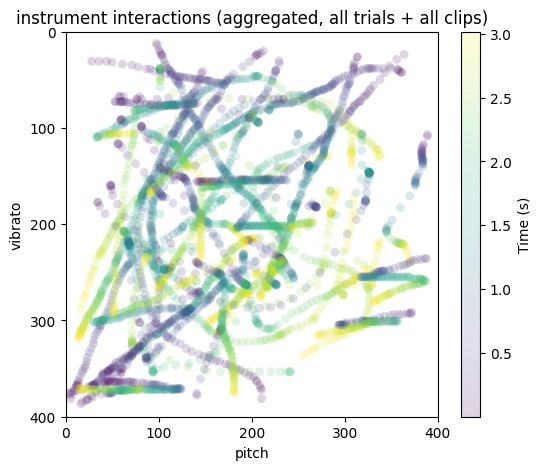

In [53]:
all_interactions = [trial['performances'][-1]['interactions'] for trial in scoring_trials]
plot_interactions(all_interactions, 'instrument interactions (aggregated, all trials + all clips)')

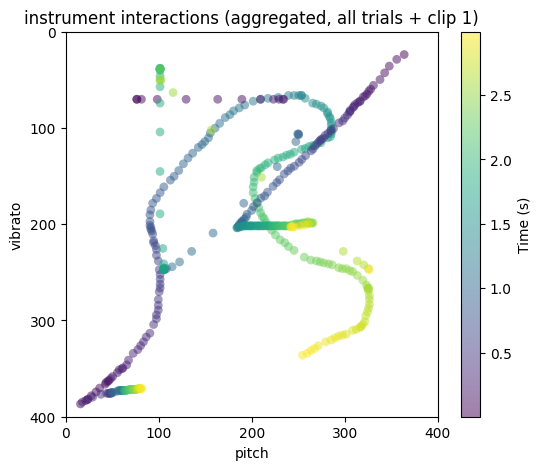

In [80]:
only_clip_0_interactions = [trial['performances'][-1]['interactions'] for trial in scoring_trials if trial['stimulus_index'] == 1]
plot_interactions(only_clip_0_interactions, 'instrument interactions (aggregated, all trials + clip 1)')

In [90]:
def plot_participant(interactions_array, title):
    plt.figure(figsize=(5, 5))
    
    # Use a colormap to assign different colors to each interaction set
    colors = plt.cm.tab10(np.linspace(0, 1, len(interactions_array)))
    
    for idx, interactions in enumerate(interactions_array):
        x_coords = []
        y_coords = []
        
        for interaction in interactions:
            if isinstance(interaction, list):
                interaction = interaction[-1]
            try:
                x_coords.append(interaction['x'])
                y_coords.append(interaction['y'])
            except KeyError:
                continue
        
        plt.scatter(x_coords, y_coords, c=[colors[idx]], s=40, alpha=0.6, edgecolors='none', label=f'Trial {idx}')
    
    plt.xlabel('pitch')
    plt.ylabel('vibrato')
    plt.xlim([0, 400])
    plt.ylim([400, 0])
    plt.xticks(np.arange(0, 401, 100))
    plt.yticks(np.arange(0, 401, 100))
    plt.title(title)
    plt.tight_layout()
    plt.show()

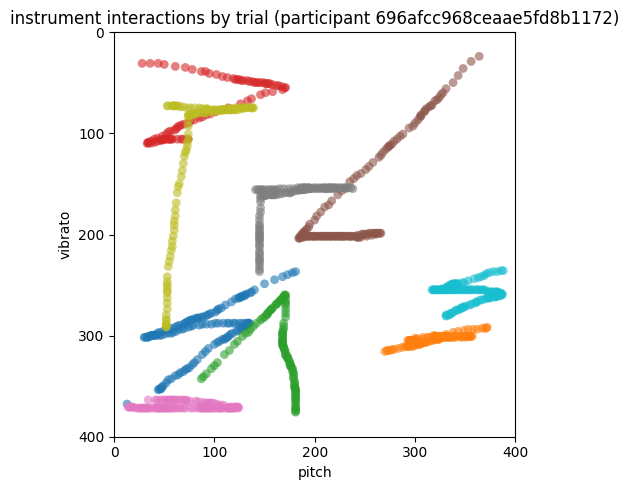

In [91]:
# just_one_participant_interactions = [trial['performances'][-1]['interactions'] for trial in scoring_trials if trial['prolific']['prolificSessionID'] == '696ae4736a1fe3a94cc2de95']
just_one_participant_interactions = [trial['performances'][-1]['interactions'] for trial in scoring_trials if trial['prolific']['prolificSessionID'] == '696afcc968ceaae5fd8b1172']
plot_participant(just_one_participant_interactions, 'instrument interactions by trial (participant 696afcc968ceaae5fd8b1172)')

In [ ]:
def parse_audio_blob(audio_blob):
    audio_bytes = bytes(audio_blob['data'])

    with io.BytesIO(audio_bytes) as bio:
        audio = AudioSegment.from_file(bio)
        
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    samples = samples / (2**15)  # 16-bit audio
    sample_rate = audio.frame_rate

    # If stereo, reshape to (n_samples, n_channels)
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))

    print(f'samples shape: {samples.shape}, sample rate: {sample_rate}, duraction: {len(samples)/sample_rate:.2f}s')

    return samples, sample_rate

# Audio(samples[:,0], rate=sample_rate)